In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from utils import data_preprocessing_util as dpu
from utils import classification_util as cu

from MLP import MLP
from nn_framework import NNFramework

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Preprocessing

In [7]:
def transformer(X):
        log_tranform_col = ['int_rate', 'annual_inc', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'total_bc_limit']
        c_root_tranform_col = ['installment', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                            'total_il_high_credit_limit', 'total_bal_ex_mort', 'avg_cur_bal', 'bc_open_to_buy', 
                            'revol_bal', 'total_rec_int', 'last_pymnt_amnt', 'tot_coll_amt','tot_cur_bal']

        for col in c_root_tranform_col:
            X[col] = np.cbrt(X[col])
        for col in log_tranform_col:
            X[col] = np.log(X[col])
        return X

def train_test(X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=40, stratify=y, test_size=0.2)
    X_te_id = X_te.pop('ID')
    X_tr_id = X_tr.pop('ID')
    return X_tr, X_te, y_tr, y_te, X_te_id, X_tr_id

In [8]:
data_path = r'data/loan-10k.lrn.csv'
df = pd.read_csv(data_path)

In [ ]:
nn = NNFramework()
data = df.copy()

Define train and test splits:

In [ ]:
y = data.pop('grade')
# X = data.pop('addr_state')
X = data
X = transformer(X)
cols = list(X.select_dtypes('object').columns)
nn.fit_encoder(X, cols)
X = nn.encode_dataset(X)
X_train, X_test, y_train, y_test, X_te_id, X_tr_id = train_test(X, y)

# Parameter experiments

## Running experiments

Define parameters:

In [8]:
random_seed = 1038
scaling = True
oversampling = True
cv_num = 5

scaler = preprocessing.StandardScaler() if scaling else None

activation_functions = ['relu', 'sigmoid']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5]
hidden_layer_sizes = [(5,), (32,), (16, 16), (10, 5, 5), (16, 8, 8), (64, 32, 32),]

Create pipelines for each parameter combination to experiment with different activation functions, learning rates, layer numbers and numbers of nodes per layer:

In [10]:
methods = []

for af in activation_functions:
    for lr in learning_rates:
        for hls in hidden_layer_sizes:
            methods.append((f'MLP-{af}-{lr}-{hls}', MLP(n_iter=5000, activation_function=af, learning_rate=lr, hidden_layer_sizes=hls)))
    
pipelines = cu.define_pipelines(methods, scaler=scaler, oversampling=oversampling)

Run the experiments, save the experiment results to csv and pickle:

In [12]:
models, model_params, model_lists = cu.run_cv_experiments(pipelines, X, y, cv_num, scoring='f1_macro', n_jobs=10, print_output=False)

df_param = pd.DataFrame(model_params).transpose()
df_param = df_param.reset_index(drop=False)
df_param = df_param.rename(columns={'index': 'model'})

for c in df_param.columns:
    if ('_num' in c) or ('_std' in c) or ('_mean' in c):
        df_param[c] = df_param[c].astype(float)

# df_param.to_csv(r'results/loan_experiments.csv', index=False)

# with open(r'results/loan_lists_experiments.pickle', 'wb') as handle:
#     pickle.dump(model_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train 5 models with 5 parameter combinations which showed the best f1 scores on the full train split. Evaluate their performance with a number of different metrics and save the results to another df:

In [119]:
results_df = pd.DataFrame()

best_model_names = df_param.sort_values(['test_score_mean'], ascending=False).head(5)['model']
for best_model_name in best_model_names:
    pipelines[best_model_name].fit(X_train, y_train)
    y_pred = pipelines[best_model_name].predict(X_test)
    eval_results = cu.eval(y_pred, y_test)

    results_df = results_df.append({
        'model': best_model_name,
        'cm': eval_results['cm'].flatten(),
        'acc': eval_results['acc'],
        'balanced_acc': eval_results['balanced_acc'],
        'precision': eval_results['precision'],
        'recall': eval_results['recall'],
        'f-score': eval_results['f-score'],
        'support': eval_results['support']
    }, ignore_index=True)

# results_df.to_csv("results/loan_5_best_trainset.csv", index=False)

Loss did not go down for 10 iterations. Stopping training at iteration 94...
Evaluation metrics:


array([[0.96875   , 0.03125   ],
       [0.05555556, 0.94444444]])

acc: 0.96
balanced_acc: 0.9565972222222222

Macro-averaged precision: 0.9565972222222222
Macro-averaged recall: 0.9565972222222222
Macro-averaged f-score: 0.9565972222222222
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 26...
Evaluation metrics:


array([[0.9375    , 0.0625    ],
       [0.05555556, 0.94444444]])

acc: 0.94
balanced_acc: 0.9409722222222222

Macro-averaged precision: 0.9312393887945671
Macro-averaged recall: 0.9409722222222222
Macro-averaged f-score: 0.9356499356499357
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 33...
Evaluation metrics:


array([[1.        , 0.        ],
       [0.05555556, 0.94444444]])

acc: 0.98
balanced_acc: 0.9722222222222222

Macro-averaged precision: 0.9848484848484849
Macro-averaged recall: 0.9722222222222222
Macro-averaged f-score: 0.9780219780219781
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 111...
Evaluation metrics:


array([[0.9375    , 0.0625    ],
       [0.11111111, 0.88888889]])

acc: 0.92
balanced_acc: 0.9131944444444444

Macro-averaged precision: 0.9131944444444444
Macro-averaged recall: 0.9131944444444444
Macro-averaged f-score: 0.9131944444444444
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Loss did not go down for 10 iterations. Stopping training at iteration 80...
Evaluation metrics:


array([[0.96875   , 0.03125   ],
       [0.05555556, 0.94444444]])

acc: 0.96
balanced_acc: 0.9565972222222222

Macro-averaged precision: 0.9565972222222222
Macro-averaged recall: 0.9565972222222222
Macro-averaged f-score: 0.9565972222222222
Macro-averaged support: None


/tmp/ipykernel_8052/1907475398.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


## Analysis

In [5]:
df_param = pd.read_csv(r'results/loan_experiments.csv')

with open(r'results/loan_lists_experiments.pickle', "rb") as input_file:
    model_lists = pickle.load(input_file)

In [6]:
model_lists_df = pd.DataFrame(model_lists).transpose()
model_lists_df = model_lists_df.reset_index(drop=False)
model_lists_df = model_lists_df.rename(columns={'index': 'model'})

model_lists_df['converged_num'] = model_lists_df.converged.apply(lambda x: sum(x))
model_lists_df['diverged'] = 5 - model_lists_df['converged_num']

model_lists_df['activation_function'] = model_lists_df.model.str.extract(r'MLP-(\w+)-.*')
model_lists_df['learning_rate'] = model_lists_df.model.str.extract(r'.*-([\d|.]+)-.*').astype(float)
model_lists_df['hidden_layer_sizes'] = model_lists_df.model.str.extract(r'MLP-.*-.*-(.*)')

accuracy_threshold = df_param['test_score_mean'].max() * 0.5

In [9]:
for c in model_lists_df.columns.difference(['model', 'activation_function', 'learning_rate', 'hidden_layer_sizes', 'converged_num', 'diverged']):
    for i in range(cv_num):
        model_lists_df[f'{c}_cv{i}'] = model_lists_df[c].apply(lambda x: x[i])

In [10]:
for i in range(5):
    model_lists_df[f'vanishing_gradients_cv{i}'] = False
    model_lists_df.loc[model_lists_df[f'converged_cv{i}'] & (model_lists_df[f'test_score_cv{i}'] < accuracy_threshold), f'vanishing_gradients_cv{i}'] = True

vg_cols = [c for c in model_lists_df.columns if 'vanishing_gradients_' in c]
model_lists_df[f'vanishing_gradients'] = pd.Series(model_lists_df[vg_cols].values.tolist())
model_lists_df[f'vanishing_gradients'] = model_lists_df[f'vanishing_gradients'].apply(lambda x: sum(x))

In [11]:
model_lists_df['all_converged'] = model_lists_df.converged.apply(lambda x: all(x))
model_lists_df['any_converged'] = model_lists_df.converged.apply(lambda x: any(x))

In [12]:
df_param = df_param.merge(model_lists_df[['model', 'all_converged', 'any_converged']], on='model', how='left')

In [13]:
max_accuracies_ids = df_param[df_param.any_converged].groupby(['hidden_layer_sizes', 'activation_function'])['test_score_mean'].idxmax()
max_accuracies_models = df_param.iloc[max_accuracies_ids.values, :]

In [14]:
id_vars = model_lists_df.columns.difference(list([c for c in model_lists_df.columns if '_cv' in c]))
model_lists_melted_df = model_lists_df.melt(id_vars=id_vars, var_name = 'metric_name', value_name='metric_value')

In [15]:
color = [(127,201,127),(190,174,212),(253,192,134),(56,108,176),(255,255,153)]
for i, rgb in enumerate(color):
    r, g, b = rgb
    color[i] = r/255.0, g/255.0, b/255.0

from matplotlib.colors import ListedColormap
cmap = ListedColormap([color[3], color[2]])

### Sigmoid vs RELU

In [16]:
def get_specific_table(model_lists_melted_df, col, accuracy_threshold):
    df = model_lists_melted_df[model_lists_melted_df.metric_name.str.contains(col)].copy()
    df['model_short'] = df['model'].str.replace('-sigmoid-', '-').str.replace('-relu-', '-')
    df = df.sort_values(by='converged')

    df.loc[:, 'cv'] = df.metric_name.str.extract(r'.*_cv(\d)').astype(int)
    df.loc[:, 'test_score_cv'] = df.apply(lambda x: x.test_score[x.cv], axis=1)
    df.loc[:, 'converged_cv'] = df.apply(lambda x: x.converged[x.cv], axis=1)

    df = df[(df.test_score_cv > accuracy_threshold) & df.converged_cv].copy()

    both_models_converged = pd.DataFrame(df.groupby(['model_short']).activation_function.nunique())
    both_models_converged = both_models_converged.reset_index(drop=False)
    both_models_converged.columns = ['model_short', 'num_models_converged']

    df = df.merge(both_models_converged, on='model_short', how='left')

    return df

#### Fitting times

In [17]:
df_fit_times = get_specific_table(model_lists_melted_df, col='fit_time', accuracy_threshold=accuracy_threshold)

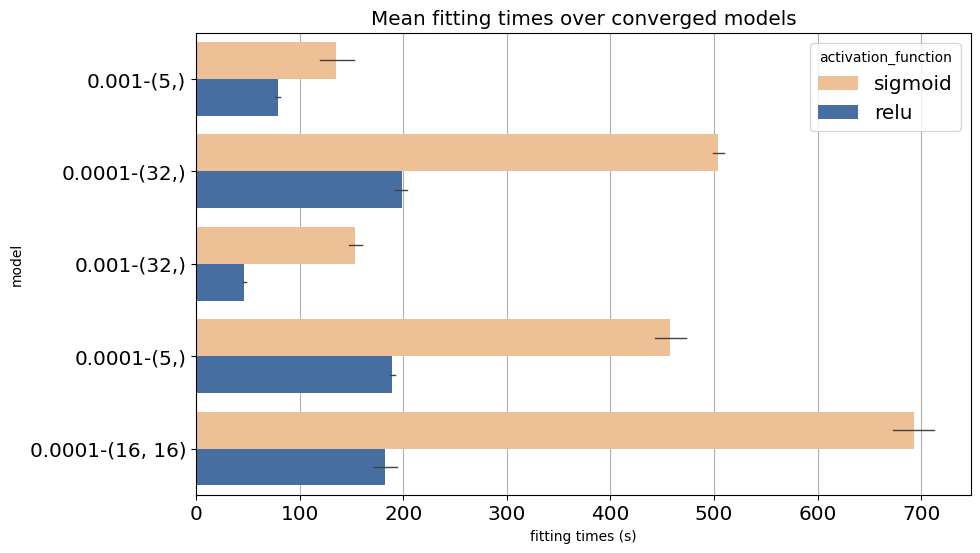

In [35]:
plt.rcParams['axes.axisbelow'] = True

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

_, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_fit_times[df_fit_times.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[2], color[3]])
yticklabels = [t.get_text().replace('MLP-', '') for t in ax.get_yticklabels()]
ax.set(title='Mean fitting times over converged models', xlabel='fitting times (s)', ylabel='model', yticklabels=yticklabels)
ax.grid(axis="x")

In [19]:
max_accuracies_models.model.unique()

array(['MLP-relu-0.0001-(10, 5, 5)', 'MLP-sigmoid-0.001-(10, 5, 5)',
       'MLP-relu-0.0001-(16, 16)', 'MLP-sigmoid-0.0001-(16, 16)',
       'MLP-relu-0.0001-(16, 8, 8)', 'MLP-sigmoid-0.001-(16, 8, 8)',
       'MLP-relu-0.0001-(32,)', 'MLP-sigmoid-0.0001-(32,)',
       'MLP-relu-0.001-(5,)', 'MLP-sigmoid-0.001-(5,)',
       'MLP-sigmoid-0.0001-(64, 32, 32)'], dtype=object)

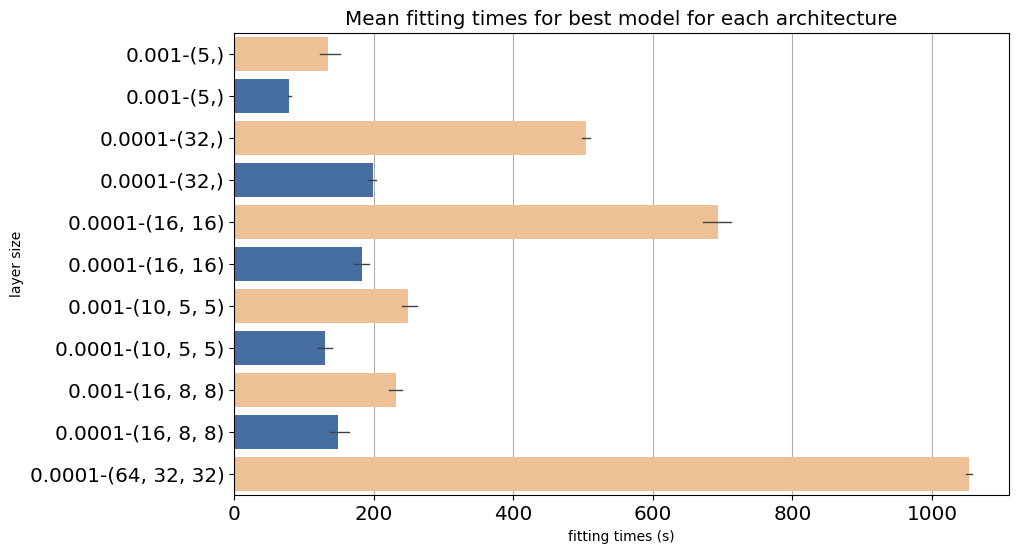

In [58]:
_, ax = plt.subplots(figsize=(10, 6))
df_fit_times_sorted = df_fit_times[df_fit_times.model.isin(max_accuracies_models.model.unique())].copy()
df_fit_times_sorted['s2'] = df_fit_times_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_fit_times_sorted['s3'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_fit_times_sorted['s1'] = df_fit_times_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_fit_times_sorted = df_fit_times_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_fit_times_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
yticklabels = [t.get_text().replace('MLP-sigmoid-', '').replace('MLP-relu-', '') for t in ax.get_yticklabels()]
ax.set(title=f'Mean fitting times for best model for each architecture', xlabel='fitting times (s)', ylabel='layer size', yticklabels=yticklabels)
ax.grid(axis="x")

#### Performance

In [21]:
df_test_scores = get_specific_table(model_lists_melted_df, col='test_score', accuracy_threshold=accuracy_threshold)

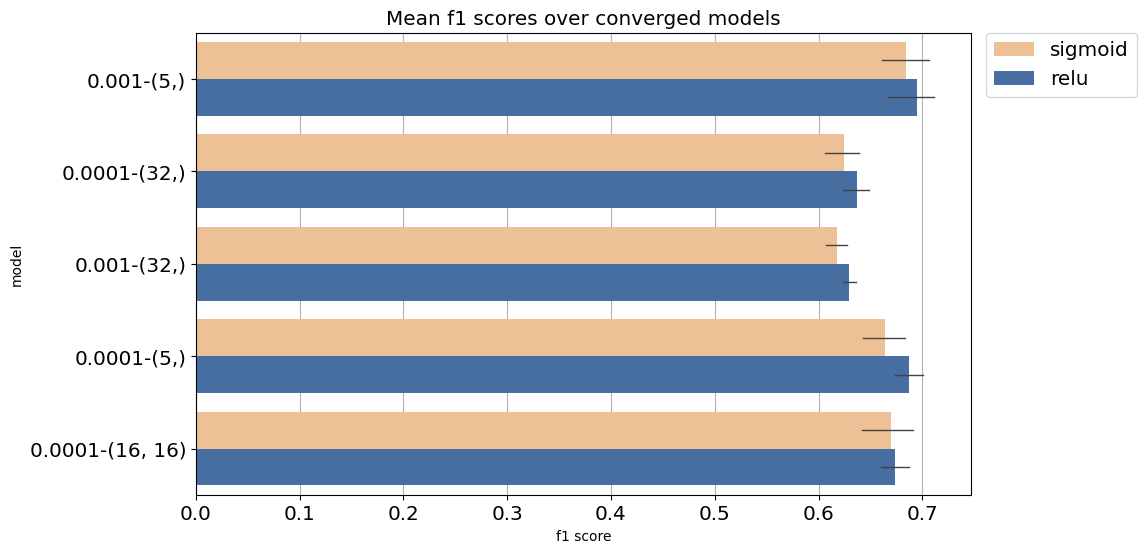

In [38]:
_, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_test_scores[df_test_scores.num_models_converged == 2], y='model_short', x='metric_value', hue='activation_function', ax=ax, errwidth=1, palette=[color[2], color[3]])
yticklabels = [t.get_text().replace('MLP-', '') for t in ax.get_yticklabels()]
ax.set(title='Mean f1 scores over converged models', xlabel='f1 score', ylabel='model', yticklabels=yticklabels)
ax.grid(axis="x")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

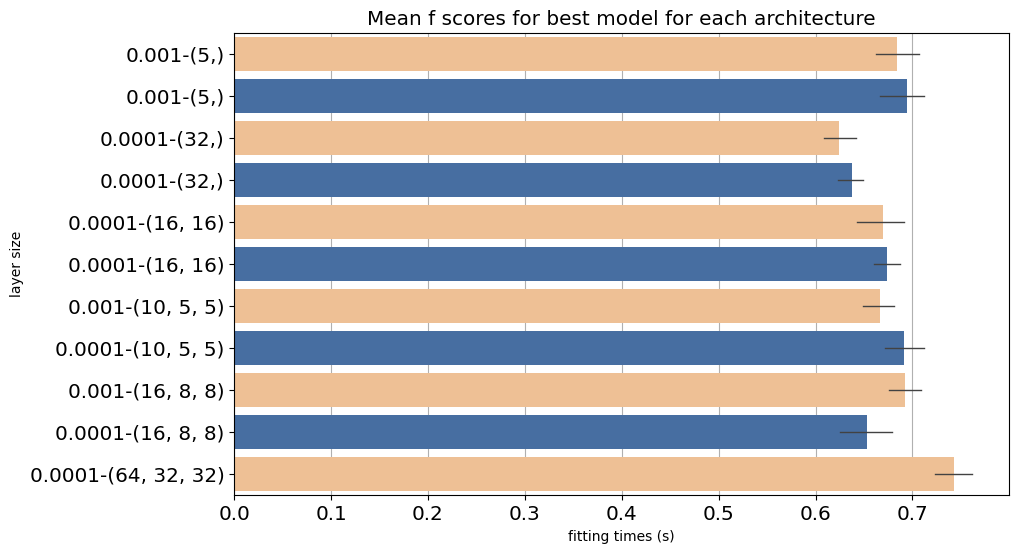

In [57]:
_, ax = plt.subplots(figsize=(10, 6))
df_test_scores_sorted = df_test_scores[df_test_scores.model.isin(max_accuracies_models.model.unique())].copy()
df_test_scores_sorted['s2'] = df_test_scores_sorted['activation_function'].apply(lambda x: 1 if x == 'sigmoid' else 2)
df_test_scores_sorted['s3'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: x)
df_test_scores_sorted['s1'] = df_test_scores_sorted['hidden_layer_sizes'].apply(lambda x: len(x))
df_test_scores_sorted = df_test_scores_sorted.sort_values(by=['s1', 's3', 's2'])
colors = [color[2], color[3]] * 6
ax = sns.barplot(data=df_test_scores_sorted, y='model', x='metric_value', ax=ax, errwidth=1, palette = colors)
yticklabels = [t.get_text().replace('MLP-sigmoid-', '').replace('MLP-relu-', '') for t in ax.get_yticklabels()]
ax.set(title=f'Mean f scores for best model for each architecture', xlabel='fitting times (s)', ylabel='layer size', yticklabels=yticklabels)
ax.grid(axis="x")

#### Convergence and vanishing gradients

Looking at gradients where accuracy is bad although training was not interrupted:

In [24]:
model_lists_df[model_lists_df[f'vanishing_gradients'] > 0]

,model,test_score,fit_time,score_time,converged,validation_losses,training_losses,gradients,converged_num,diverged,...,validation_losses_cv3,validation_losses_cv4,vanishing_gradients_cv0,vanishing_gradients_cv1,vanishing_gradients_cv2,vanishing_gradients_cv3,vanishing_gradients_cv4,vanishing_gradients,all_converged,any_converged
33,"MLP-sigmoid-0.0001-(10, 5, 5)","[0.10929831215110512, 0.11198727079936911, 0.1...","[30.110119581222534, 32.73074531555176, 31.971...","[0.012003421783447266, 0.012002706527709961, 0...","[True, True, True, True, True]","[[2.024352612643357, 1.9791399704622272, 1.959...","[[2.0238658719809663, 1.9787351551695647, 1.95...","[{0: [-4.715472932938383e-20, 1.99512163013210...",5,0,...,"[2.0241068368502066, 1.9789475366108282, 1.959...","[2.0234501226229638, 1.9783149072868766, 1.958...",True,True,True,True,True,5,True,True
34,"MLP-sigmoid-0.0001-(16, 8, 8)","[0.14503180173575486, 0.1382327129199514, 0.13...","[29.31906247138977, 29.24304175376892, 28.9679...","[0.013002395629882812, 0.014003515243530273, 0...","[True, True, True, True, True]","[[2.025069588598991, 1.968369636852267, 1.9526...","[[2.0252607031623895, 1.9686355349365343, 1.95...","[{0: [-5.340243495341603e-20, -7.4003027823871...",5,0,...,"[2.025705121774348, 1.9688663629557737, 1.9531...","[2.025618408838374, 1.9687688728615118, 1.9530...",True,True,True,True,True,5,True,True
53,"MLP-sigmoid-0.1-(64, 32, 32)","[0.06397250401906979, 0.06388642413487133, 0.0...","[25.759287357330322, 25.599381685256958, 25.82...","[0.016093969345092773, 0.01600790023803711, 0....","[True, True, True, True, True]","[[2.5989445665495534, 2.599752490148679, 2.600...","[[2.599304968767627, 2.6001130135459496, 2.600...","[{0: [-8.18428681211493e-20, 1.031084764818940...",5,0,...,"[2.5996529147122387, 2.6004210162617576, 2.600...","[2.5995786664679685, 2.600386048637301, 2.6006...",True,True,True,True,True,5,True,True
54,"MLP-sigmoid-0.5-(5,)","[0.2954950707714151, 0.33267799580229024, 0.24...","[29.599032163619995, 22.708889961242676, 24.40...","[0.013002872467041016, 0.013002634048461914, 0...","[True, True, True, True, True]","[[1.7866938533125654, 1.5728192624235455, 2.02...","[[1.7780660446759549, 1.5645877004305653, 2.03...","[{0: [-4.5787757673415085e-20, -5.076203152660...",5,0,...,"[1.5929400162144007, 1.5282033725352362, 1.633...","[2.1961785728495036, 2.0423870636701187, 2.112...",True,True,True,True,True,5,True,True
55,"MLP-sigmoid-0.5-(32,)","[0.3314396773856682, 0.4166310701813084, 0.379...","[19.24982476234436, 32.96669030189514, 28.2451...","[0.01700305938720703, 0.013510465621948242, 0....","[True, True, True, True, True]","[[4.917397131288817, 6.4579357150833125, 4.391...","[[4.908680997094986, 6.480515459932468, 4.3530...","[{0: [6.714321706438284e-20, -2.07823549726969...",5,0,...,"[7.287407510599684, 3.9323876623969727, 5.8854...","[4.974965021721114, 4.632729743426837, 6.48907...",True,False,False,True,True,3,True,True
56,"MLP-sigmoid-0.5-(16, 16)","[0.06397250401906979, 0.08423062237495227, 0.1...","[17.19893980026245, 36.91126084327698, 20.7322...","[0.013003110885620117, 0.013003110885620117, 0...","[True, True, True, True, True]","[[7.348409010352118, 7.351834046184027, 7.3528...","[[7.350219242536526, 7.353644415008772, 7.3547...","[{0: [-6.849302271969178e-20, 1.76563708455290...",5,0,...,"[5.7561226000511985, 4.018627969458383, 4.1422...","[3.4894787857765377, 5.645712905221493, 4.5756...",True,True,True,True,True,5,True,True
57,"MLP-sigmoid-0.5-(10, 5, 5)","[0.06397250401906979, 0.06388642413487133, 0.0...","[20.55638289451599, 21.301363945007324, 20.701...","[0.012002944946289062, 0.012002706527709961, 0...","[True, True, True, True, True]","[[2.4560660066639164, 2.4561601314883514, 2.45...","[[2.4563199505783277, 2.4564142577175847, 2.45...","[{0: [-7.152762654318269e-20, -3.7991304409090...",5,0,...,"[2.4566409127172886, 2.4567153533599804, 2.456...","[2.4566385783443803, 2.456714293187837, 2.4567...",True,True,True,True,True,5,

In [41]:
g_id = 55
i = 4 #i=4 vanishing  gradient issue i=0 normal behavior
gradients = model_lists_df.loc[g_id, 'gradients'][i]
f1 = model_lists_df.loc[g_id,f'test_score_cv{i}']

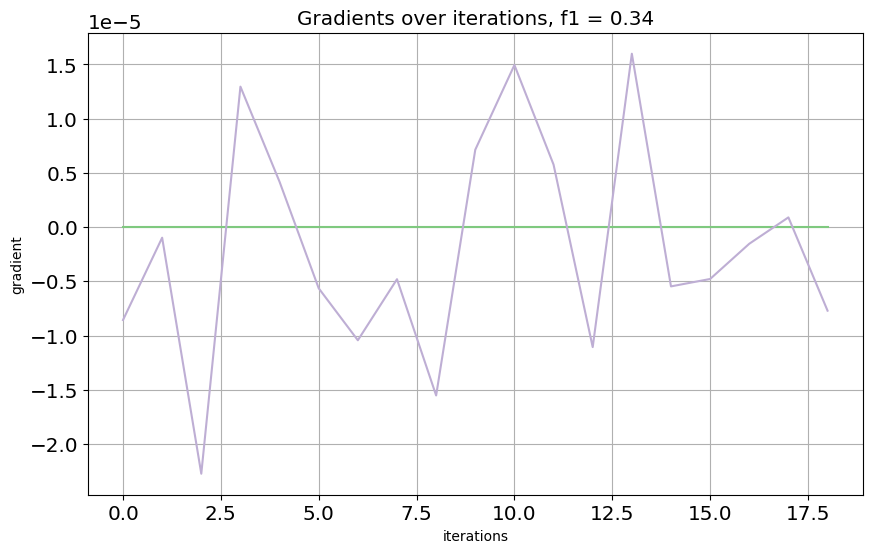

In [42]:
_, ax = plt.subplots(figsize=(10, 6))
for j, grad in gradients.items():
    ax = sns.lineplot(x=range(len(grad)), y=grad, color=color[j])
ax.set(title=f'Gradients over iterations, f1 = {f1:.2}', xlabel='iterations', ylabel='gradient')
ax.grid()

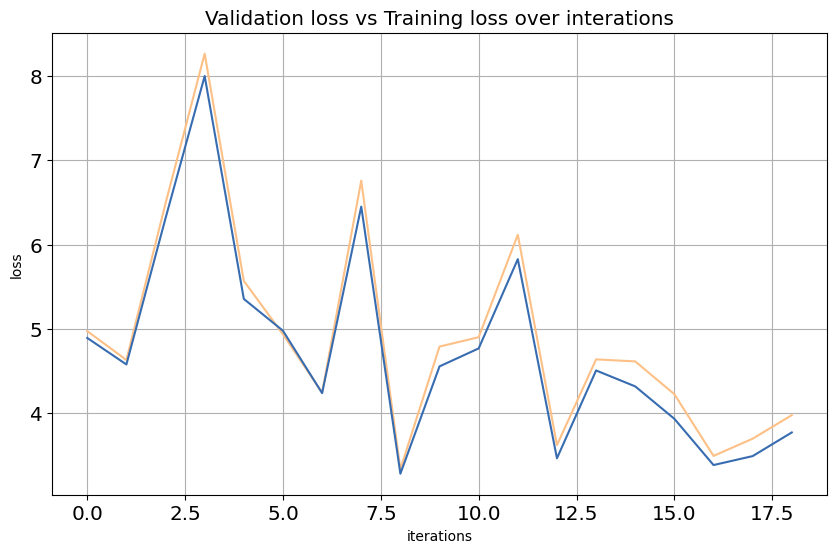

In [43]:
_, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'validation_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'validation_losses_cv{i}'], color=color[2])
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'training_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'training_losses_cv{i}'], color=color[3])
ax.set(title=f'Validation loss vs Training loss over interations', xlabel='iterations', ylabel='loss')
ax.grid()

In [54]:
g_id = 55
i = 1 #i=4 vanishing  gradient issue i=0 normal behavior
gradients = model_lists_df.loc[g_id, 'gradients'][i]
f1 = model_lists_df.loc[g_id,f'test_score_cv{i}']

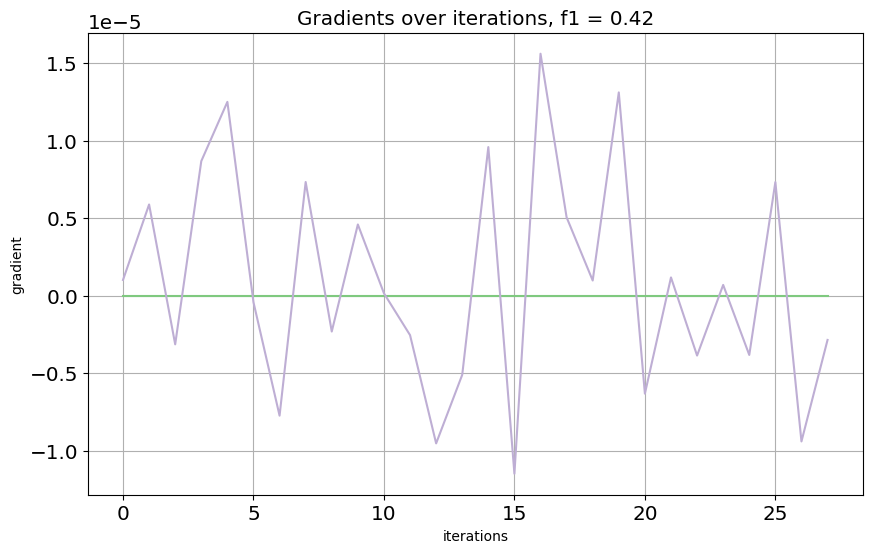

In [55]:
_, ax = plt.subplots(figsize=(10, 6))
for j, grad in gradients.items():
    ax = sns.lineplot(x=range(len(grad)), y=grad, color=color[j])
ax.set(title=f'Gradients over iterations, f1 = {f1:.2}', xlabel='iterations', ylabel='gradient')
ax.grid()

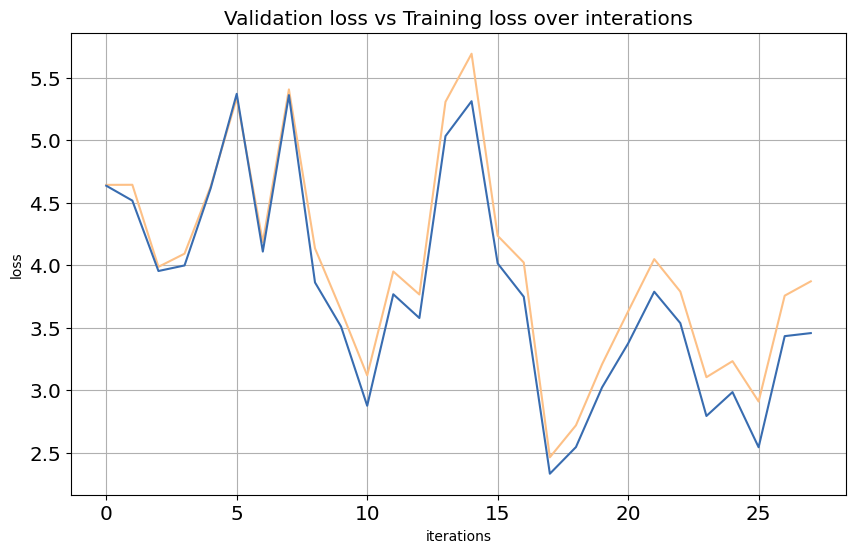

In [56]:
_, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'validation_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'validation_losses_cv{i}'], color=color[2])
sns.lineplot(x=range(len(model_lists_df.loc[g_id, f'training_losses_cv{i}'])), y=model_lists_df.loc[g_id, f'training_losses_cv{i}'], color=color[3])
ax.set(title=f'Validation loss vs Training loss over interations', xlabel='iterations', ylabel='loss')
ax.grid()

In [31]:
plt.rcParams['axes.axisbelow'] = True

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


C:\Users\Alina\AppData\Local\Temp\ipykernel_12500\560291286.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


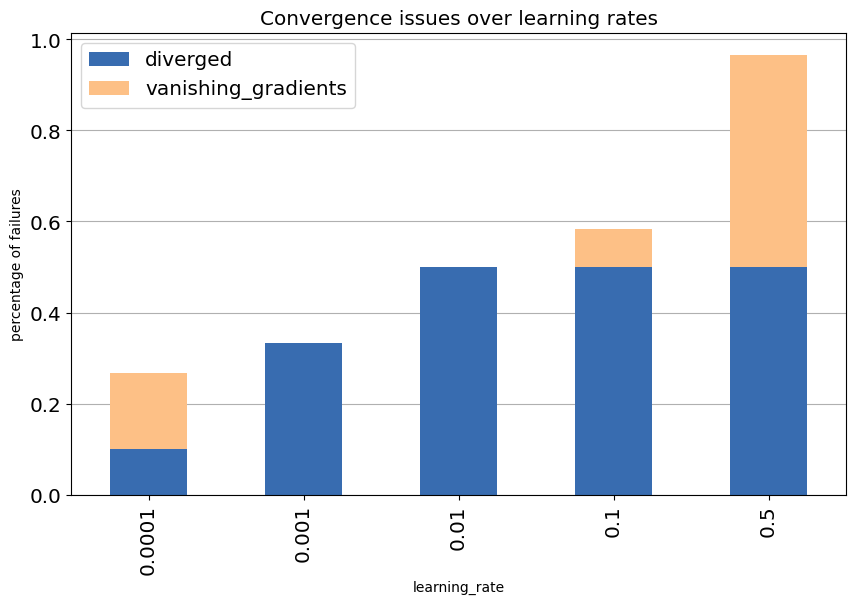

In [32]:
_, ax = plt.subplots(figsize=(10, 6))
failure_count = model_lists_df.groupby(['learning_rate'])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
failure_count.plot(ax = ax, kind='bar', stacked=True, cmap=cmap)
ax.set(title=f'Convergence issues over learning rates', ylabel='percentage of failures')
ax.grid(axis='y')

In [33]:
def get_failure_df(model_lists_df, by_col='hidden_layer_sizes'):
    failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)
    failure_count = failure_count.reset_index(drop=False)
    failure_count['layer_size_len'] = failure_count[by_col].apply(lambda x: len(x))
    failure_count = failure_count.sort_values(by='layer_size_len')
    failure_count = failure_count.drop('layer_size_len', axis=1)
    failure_count = failure_count.set_index(by_col)
    return failure_count

C:\Users\Alina\AppData\Local\Temp\ipykernel_12500\3839886018.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  failure_count = model_lists_df.groupby([by_col])['diverged', 'vanishing_gradients'].sum() / (12 * 5)


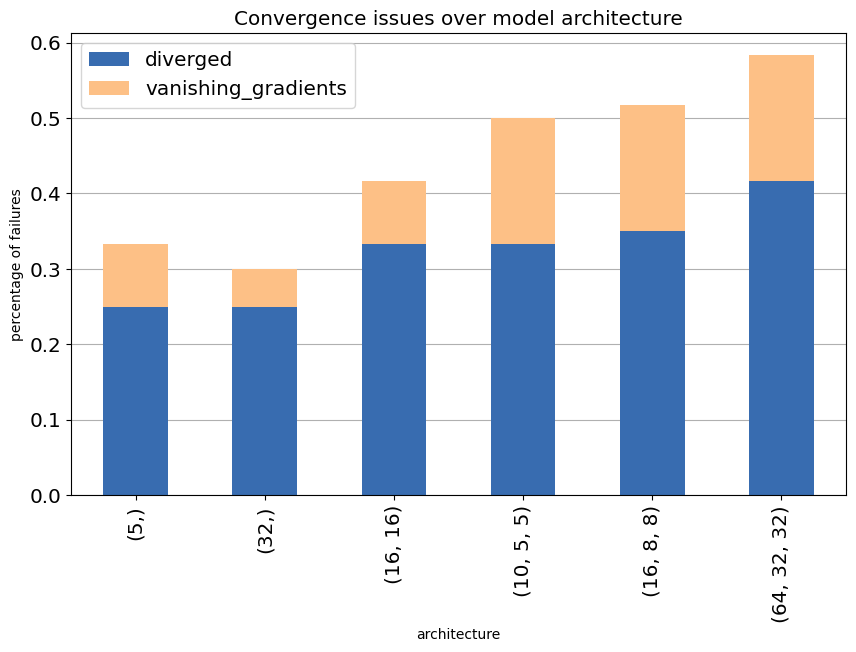

In [34]:
_, ax = plt.subplots(figsize=(10, 6))
failure_count = get_failure_df(model_lists_df, by_col='hidden_layer_sizes')
failure_count.plot(ax = ax, kind='bar', stacked=True, colormap=cmap)
ax.set(title=f'Convergence issues over model architecture', ylabel='percentage of failures', xlabel='architecture')
ax.grid(axis='y')